# Part 3: Train a DQN on a Ray cluster

In [1]:
# In this part, you will connect to your Ray cluster.
# TODO: change the IP address of your head node.

import ray
ray.init(address="ray://172.31.2.226:10001")

2025-03-28 04:28:09,485	INFO client_builder.py:244 -- Passing the following kwargs to ray.init() on the server: log_to_driver
SIGTERM handler is not set because current thread is not the main thread.


Python version:,3.10.12
Ray version:,2.44.0
Dashboard:,http://127.0.0.1:8265


(pid=3418, ip=172.31.3.196) E0328 04:28:14.546811220    3418 chttp2_server.cc:1063]                UNKNOWN:No address added out of total 1 resolved for '0.0.0.0:10062' {created_time:"2025-03-28T04:28:14.546701756+00:00", children:[UNKNOWN:Failed to add any wildcard listeners {created_time:"2025-03-28T04:28:14.54669006+00:00", children:[UNKNOWN:Unable to configure socket {fd:21, created_time:"2025-03-28T04:28:14.546622636+00:00", children:[UNKNOWN:Address already in use {syscall:"listen", os_error:"Address already in use", errno:98, created_time:"2025-03-28T04:28:14.546611365+00:00"}]}, UNKNOWN:Unable to configure socket {fd:21, created_time:"2025-03-28T04:28:14.54668319+00:00", children:[UNKNOWN:Address already in use {created_time:"2025-03-28T04:28:14.54667619+00:00", errno:98, os_error:"Address already in use", syscall:"bind"}]}]}]}
(pid=3418, ip=172.31.3.196) [2025-03-28 04:28:14,617 C 3418 3418] grpc_server.cc:127:  Check failed: server_ Failed to start the grpc server. The specifi

(GlobalNet pid=23488) Initializing an Global Network on worker with IP: 172.31.2.226
(Agent pid=2212, ip=172.31.15.230) Initializing an Actor on worker with IP: 172.31.15.230
(Agent pid=2563, ip=172.31.5.161) Initializing an Actor on worker with IP: 172.31.5.161
(Agent pid=3607, ip=172.31.3.196) Initializing an Actor on worker with IP: 172.31.3.196
(Agent pid=3607, ip=172.31.3.196) Initializing an Actor on worker with IP: 172.31.3.196
(Agent pid=3606, ip=172.31.3.196) Initializing an Actor on worker with IP: 172.31.3.196
(Agent pid=3606, ip=172.31.3.196) Initializing an Actor on worker with IP: 172.31.3.196


In [2]:
# Print the status of the Ray cluster.
print('''This cluster consists of
    {} nodes in total
    {} CPU resources in total
    {} Memory resources in total
    {} Object store memory resources in total
    '''.format(len(ray.nodes()), ray.cluster_resources()['CPU'], 
           ray.cluster_resources()['memory'] / (1024*1024*1024), 
           ray.cluster_resources()['object_store_memory'] / (1024*1024*1024)))

This cluster consists of
    5 nodes in total
    10.0 CPU resources in total
    25.581039430573583 Memory resources in total
    10.963302610442042 Object store memory resources in total
    


In [3]:
%%time

'''
(Optional testing code) 
Test your Ray cluster, see the outputs to check if all nodes are ready to work
the output should be like "123 tasks on 1.2.3.4 with Gym version 0.21.0".
By default, you have 5 nodes, one is the head node, the others are workers (actors).
'''
import socket
import time
from collections import Counter

@ray.remote
def f():
    import torch
    import gym
    time.sleep(0.001)
    return socket.gethostbyname(socket.gethostname()),gym.__version__

object_ids = [f.remote() for _ in range(1000)]
results = ray.get(object_ids)

print('Tasks executed')

stats = {}

for ip_address, version in results:
    if ip_address in stats:
        stats[ip_address] = (stats[ip_address][0] + 1, version)
    else:
        stats[ip_address] = (1, version)

for ip_address, (num_tasks, version) in stats.items():
    print('    {} tasks on {} with Gym version {}'.format(num_tasks, ip_address, version))

Tasks executed
    563 tasks on 172.31.15.230 with Gym version 0.21.0
    431 tasks on 172.31.5.161 with Gym version 0.21.0
    4 tasks on 172.31.3.196 with Gym version 0.21.0
    2 tasks on 172.31.2.226 with Gym version 0.21.0
CPU times: user 505 ms, sys: 130 ms, total: 635 ms
Wall time: 8.29 s


In [4]:
import random
import numpy as np
import torch
import ray
import gym
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import time
import socket
import matplotlib.pyplot as plt

In [5]:
'''
DO NOT MODIFY THIS CELL.
We use DQN as our RL training algorithm.
See https://huggingface.co/learn/deep-rl-course/en/unit3/deep-q-algorithm to get more infomation about DQN.
'''
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_unit=64,
                 fc2_unit=64):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_unit)
        self.fc2 = nn.Linear(fc1_unit, fc2_unit)
        self.fc3 = nn.Linear(fc2_unit, action_size)

    def forward(self, x):
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
'''
DO NOT MODIFY THIS CELL.
The ReplayBuffer is an essential component in Deep Q-Networks (DQN)
It stores the Agent's experiences at each time step, comprised of the state, action, reward, next state, and done flag, in a memory buffer.
This allows for the experiences to be randomly sampled later to train the neural network.
'''
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [7]:
'''
DO NOT MODIFTY THIS CELL.
The Learner is interacting with the environment to learn an optimal policy for decision-making.
The logic is the same as the Agent in the DQN algorithm, with only a different name here.
'''
class Learner:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize a Learner object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        random.seed(seed)
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed)
        self.qnetwork_target = QNetwork(state_size, action_size, seed)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, gamma)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))

        # Get expected Q values from local model
        q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(q_expected, q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [8]:
'''
This class implements a global network (i.e., a parameter server) in a distributed training setup.
It holds a global model that aggregates updates from multiple Agent actors to collectively learn a policy.
GlobalNet will also periodically test the learned policy in a dedicated test environment.
'''

@ray.remote(num_cpus=2)
class GlobalNet:
    def __init__(self, state_size, action_size, seed, fc1_unit=64, fc2_unit=64):
        random.seed(seed)
        self.local_model = QNetwork(state_size, action_size, seed, fc1_unit, fc2_unit)
        self.test_env = gym.make('LunarLander-v2')
        self.test_env.seed(TEST_SEED)
        print(f"Initializing an Global Network on worker with IP: {self.get_worker_ip()}")

    def get_worker_ip(self):
        """Get the current worker's IP address."""
        hostname = socket.gethostname()
        ip_address = socket.gethostbyname(hostname)
        return ip_address

    def average_weights(self, actors):
        """
        Collects weights from all given actors and averages them to update the global model.

        Params:
            actors: list of actor handlers from which to collect weights
        """
        weights_futures = [actor.get_weights.remote() for actor in actors]
        local_weights_list = ray.get(weights_futures)
        local_state_dict = self.local_model.state_dict()

        # Initialize average weights
        average_local_weights = {k: torch.zeros_like(v) for k, v in local_state_dict.items()}
        # Sum all the weights
        for local_state in local_weights_list:
            for k, v in local_state.items():
                average_local_weights[k] += v
        # Average the weights
        for k in average_local_weights.keys():
            average_local_weights[k] = average_local_weights[k] / len(local_weights_list)

        self.local_model.load_state_dict(average_local_weights)

    def get_weights(self):
        """
        Returns the weights of the local model in the global network.
        """
        return self.local_model.state_dict()

    def play_game(self, max_timesteps=200, num_games=10):
        total_reward_sum = 0
        for _ in range(num_games):
            state = self.test_env.reset()
            total_reward = 0
            for t in range(max_timesteps):
                state_tensor = torch.from_numpy(state).float().unsqueeze(0)
                with torch.no_grad():
                    action_values = self.local_model(state_tensor)
                action = torch.argmax(action_values).item()

                next_state, reward, done, _ = self.test_env.step(action)
                total_reward += reward
                state = next_state
                if done:
                    break
            total_reward_sum += total_reward
        average_reward = total_reward_sum / num_games
        return average_reward

In [9]:
'''
    This is a distributed Agent class for parallel training in reinforcement learning environments using Ray.
    Each Agent has its own environment and own learner for training.
    Each Agent instance runs in different nodes and is responsible for collecting experiences
    by interacting with its own environment and synchronizing with the global network.
'''

@ray.remote(num_cpus=2)
class Agent:
    def __init__(self, state_size, action_size, seed):
        """
        Initialize an Agent object.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        random.seed(seed)
        self.learner = Learner(state_size, action_size, seed)

        # set game environment for training
        self.env = gym.make("LunarLander-v2")
        self.env.seed(seed)

        self.max_t = max_time_steps
        self.eps_end = 0.01
        self.eps_decay = 0.995
        self.eps = 1.0
        print(f"Initializing an Actor on worker with IP: {self.get_worker_ip()}")

    def get_worker_ip(self):
        """Get the current worker's IP address."""
        hostname = socket.gethostname()
        ip_address = socket.gethostbyname(hostname)
        return ip_address

    def synchronize_with_global(self, global_net):
        """
        Synchronize the local model weights with the global model by fetching the global model's weights.
        Params:
            global_net: The handler for the GlobalNet actor.
        """
        global_weights = ray.get(global_net.get_weights.remote())
        self.learner.qnetwork_local.load_state_dict(global_weights)

    def train(self, num_episodes):
        """
        Train the learner's local model in the given environment.
        Params
        ======
            num_episodes (int): Number of episodes to train
        """
        for episode in range(num_episodes):
            state = self.env.reset()
            score = 0
            for t in range(self.max_t):
                action = self.learner.act(state, self.eps)
                next_state, reward, done, _ = self.env.step(action)
                self.learner.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
            self.eps = max(self.eps_end, self.eps_decay * self.eps)  # decrease epsilon

    def get_weights(self):
        """
        Returns the weights of the learner's local models.
        """
        return self.learner.qnetwork_local.state_dict()

Episode 0 finished.
Episode 0	Average Score: -132.32
Episode 1 finished.
Episode 1	Average Score: -244.82
Episode 2 finished.
Episode 2	Average Score: -831.36
Episode 3 finished.
Episode 3	Average Score: -716.29
Episode 4 finished.
Episode 4	Average Score: -670.74
Episode 5 finished.
Episode 5	Average Score: -694.80
Episode 6 finished.
Episode 6	Average Score: -919.83
Episode 7 finished.
Episode 7	Average Score: -887.68
Episode 8 finished.
Episode 8	Average Score: -833.93
Episode 9 finished.
Episode 9	Average Score: -787.67
Episode 10 finished.
Episode 10	Average Score: -692.82
Episode 11 finished.
Episode 11	Average Score: -937.50
Episode 12 finished.
Episode 12	Average Score: -862.89
Episode 13 finished.
Episode 13	Average Score: -741.65
Episode 14 finished.
Episode 14	Average Score: -695.18
Episode 15 finished.
Episode 15	Average Score: -606.42
Episode 16 finished.
Episode 16	Average Score: -386.69
Episode 17 finished.
Episode 17	Average Score: -340.42
Episode 18 finished.
Episode 1

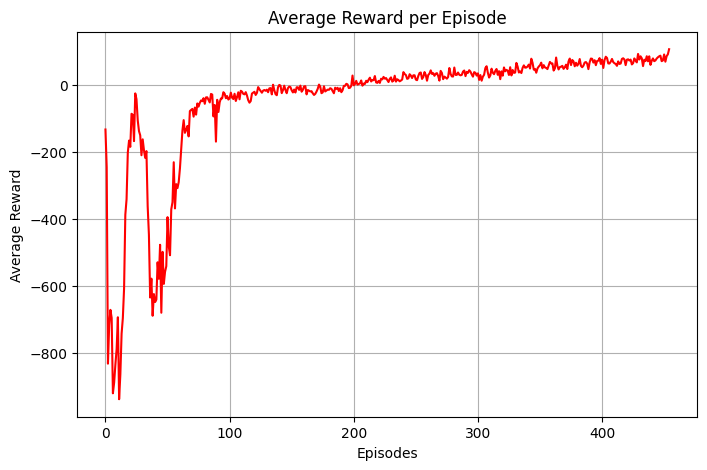

In [10]:
'''
The driver code to run the distributed training on your Ray cluster. 
'''

# set random seed
SEED= 0
TEST_SEED = 42
random.seed(SEED)
# env config
state_size = 8
action_size = 4

"""
TODO: Task 6
"""
# hyperparameters you could tune
# Task 6 TODO: try different values of the following three hyperparameters once you have finished the other tasks.
# Default settings: batch_size = 64, num_epochs_actor_train = 1, num_agents = 4 
batch_size = 64  # the minibatch size
num_epochs_actor_train = 1  # how many epochs an Agent actor trains before synchronize with GlobalNet
num_agents = 4  # how many Agent actors to train in parallel
"""
End of Task 6
"""

# hyperprameters you don't need to tune
buffer_size = int(1e5)  # replay buffer size
gamma = 0.99  # discount factor
tau = 1e-3  # for soft update of target parameters
learning_rate = 5e-4  # learning rate
update_every = 4  # how often to update the network
max_time_steps = 1000  # max time steps in an episode for train
num_episodes = 1000  # how many episodes for training

"""
TODO: Task 1
"""
# Task 1.1 TODO: Initialize a GlobalNet actor and all N Agent actors where N = num_agents
# IMPORTANT: Each agent should take a different random seed so that each covers different random behaviors

# TODO: Your code here...
global_actor = GlobalNet.remote(state_size, action_size, SEED) # Initialize a GlobalNet actor
agent_actors = [Agent.remote(state_size, action_size, random.randint(1, 500)) for i in range(num_agents)] # Initialize all N Agent actors
time.sleep(1) # This line serves as a barrier. Do not modify this line.

# Task 1.2 TODO: Synchronize GlobalNet's model weights to all Agents at the very beginning

# TODO: Your code here...
for agent in agent_actors:
    agent.synchronize_with_global.remote(global_actor) # Synchronize GlobalNet's model weights to all Agents
"""
End of Task 1
"""


# Initialize timers
times_update = []
times_sync = []
times_train = []
total_start_time = time.time()

average_game_reward = 0
avg_reward_list = []

for episode in range(num_episodes):
    """
    TODO: Task 2 to Task 5
    """

    # Task 2 TODO: Train all agents in parallel
    # Hint: Insert a barrier by calling ray.get(X_future)
    start_time = time.time()

    # TODO: Your code here... 
    train_future = [agent.train.remote(num_epochs_actor_train) for agent in agent_actors]  # Train agents asynchronously
    ray.get(train_future) # Call training in parallel
    
    end_time = time.time()
    times_train.append(end_time - start_time)
    
    # Task 3 TODO: Collect trained weights from each Agent actor and update GlobalNet
    start_time = time.time()

    # TODO: Your code here... 
    ray.get(global_actor.average_weights.remote(agent_actors)) # Collect trained weights from each Agent actor and update GlobalNet
    
    end_time = time.time()
    times_update.append(end_time - start_time)
    
    # Task 4 TODO: Each Agent actor performs a model weight synchronization by fetching the global model from GlobalNet
    start_time = time.time()

    # TODO: Your code here...
    sync_future = [agent.synchronize_with_global.remote(global_actor) for agent in agent_actors] #Perform a model weight synchronization by fetching the global model from GlobalNet
    ray.get(sync_future)
    
    end_time = time.time()
    times_sync.append(end_time - start_time)
    print(f'Episode {episode} finished.')

    # Task 5.1 TODO: Test the global model in GlobalNet and print the score here
    
    # TODO: Your code here...
    average_reward = ray.get(global_actor.play_game.remote()) # Play the game in GlobalNet and print the score here
    avg_reward_list.append(average_reward)
    print(f'Episode {episode}\tAverage Score: {average_reward:.2f}')
  
    # Task 5.2 and 5.3 TODO: Set the termination condition and save the GlobalNet weights as a checkpoint file
    # Hint: Call torch.save(your_model_weights, './model_checkpoint.pth') to save a model checkpoint
    
    # TODO: Your code here
    if average_reward >= 100 or episode == 1000: # Termination condition
        torch.save(ray.get(global_actor.get_weights.remote()), './model_checkpoint.pth') # Save the GlobalNet weights as a checkpoint file
        break
    """
    End of Task 2 to Task 5
    """


total_end_time = time.time()

print(f"Total duration: {total_end_time - total_start_time:.2f} seconds")
print(f"Average time for training: {np.mean(times_train):.2f} seconds")
print(f"Average time for updating: {np.mean(times_update):.2f} seconds")
print(f"Average time for synchronizing: {np.mean(times_sync):.2f} seconds")

# Plot Average Reward Timeline
plt.figure(figsize=(8, 5))
plt.plot(range(0, len(avg_reward_list)), avg_reward_list, color='r', label='Average Reward')

# Labels and title
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode')
plt.grid(True)
plt.show()

In [11]:
ray.shutdown()

# Visualize the game playing just for fun

The code snippets below are fully implemented and are optional. 
It provides a way for you to visualize how your trained model plays Lunar Lander. 

In [ ]:
import random
import numpy as np
import torch
import gym
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import time
import socket
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
'''
Duplicate classes needed for testing
'''
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_unit=64,
                 fc2_unit=64):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_unit)
        self.fc2 = nn.Linear(fc1_unit, fc2_unit)
        self.fc3 = nn.Linear(fc2_unit, action_size)

    def forward(self, x):
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

        
'''
The Agent is interacting with the environment to learn an optimal policy for decision-making.
'''
class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        random.seed(seed)
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed)
        self.qnetwork_target = QNetwork(state_size, action_size, seed)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))

        # Get expected Q values from local model
        q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(q_expected, q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [ ]:
'''
Load the previously saved trained model from the last checkpoint 
and do tests to display a visualization of the game being played.
'''
import gym
import torch
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML
import random
# set random seed
SEED=0
TEST_SEED=42
random.seed(SEED)

# hyper parameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64  # minibatch size
GAMMA = 0.99  # discount factor
TAU = 1e-3  # for soft update of target parameters
LR = 5e-4  # learning rate
UPDATE_EVERY = 4  # how often to update the network
MAX_TIME_STEPS= 1000  # max time steps in an episode
num_episodes = 1000   # how many episodes for training

random.seed(0)
env = gym.make('LunarLander-v2')
env.seed(42)
agent = Agent(state_size=8, action_size=4, seed=0)

# TODO: You may need to modify the path accordingly if the default does not match.
model_path='./model_checkpoint.pth'
agent.qnetwork_local.load_state_dict(torch.load(model_path, map_location='cpu'))

def display_animation(frames):
    """
    Take a list of frames and display them as an animation.
    """
    plt.figure(figsize=(5, 3))
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml()))

# run several episodes and show games
for i in range(5):
    state = env.reset()
    frames = []
    for j in range(1000):    # set max steps to 1000
        action = agent.act(state)
        frames.append(env.render(mode="rgb_array"))
        state, reward, done, _ = env.step(action)
        if done:
            break
    display_animation(frames)
env.close()